In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
# mpl.rcParams['figure.dpi'] = 300
import os
import sys
import pickle
import json
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import nibabel as nib
from nilearn import plotting,image

/Users/finnes/anaconda3/envs/hcp7t/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import sys
sys.path.append("/Users/finnes/Downloads/MantelTest-1.2.10/")
import Mantel

# This function comes from here: https://github.com/jwcarr/MantelTest

# And it **drastically** speeds up the permutation-test step for RSA

## Set directory names

In [3]:
top_dir = "/Users/finnes/Documents/HCP_7T/"
data_dir = "all_shen268_roi_ts/"
!ls $top_dir$data_dir | head -5

100610_MOVIE1_7T_AP_shen268_roi_ts.txt
100610_MOVIE1_7T_AP_shen268_roi_ts_gsr.txt
100610_MOVIE2_7T_PA_shen268_roi_ts.txt
100610_MOVIE2_7T_PA_shen268_roi_ts_gsr.txt
100610_MOVIE3_7T_PA_shen268_roi_ts.txt


## Read in behavioral data

#### Read in unrestricted behavioral data:

In [4]:
unres_behav_data = pd.read_csv(top_dir+'unres_behav_data.csv', 
                         dtype={'Subject': 'str'})
unres_behav_data.set_index("Subject", inplace=True)
print(unres_behav_data.shape)
unres_behav_data.head()

(184, 382)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0,38.6,84.84,85.31,1.92,1,1.88
102311,S500,Q06,F,26-30,True,1,1,4,100.0,True,...,4.4,122.25,110.45,1,52.2,98.31,99.06,1.80,0,1.80
102816,Q3,Q03,F,26-30,True,1,1,4,100.0,True,...,5.2,122.25,111.41,1,52.6,98.31,97.68,1.72,1,1.68
104416,S900,Q09,F,31-35,True,2,2,4,100.0,True,...,2.8,101.12,87.11,0,38.6,95.36,93.48,1.92,1,1.88
105923,MEG2,Q07,F,31-35,True,2,2,4,100.0,True,...,5.2,122.25,111.41,0,38.6,97.26,96.41,1.88,1,1.84


#### Read in restricted behavioral data (accessing csv file requires applying for access and signing a DUA through HCP):

In [5]:
res_behav_data = pd.read_csv(top_dir+"res_behav_data.csv", dtype={'Subject':str})
res_behav_data = res_behav_data.set_index("Subject")
print(res_behav_data.shape)
res_behav_data.head()

(184, 200)


,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,Ethnicity,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
Subject,,,,,,,,,,,,,,,,,,,,,
100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
102311,26,True,MZ,MZ,51679_81543,51679,81543,NaN,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
102816,30,True,MZ,MZ,51418_81283,51418,81283,NaN,Black or African Am.,Not Hispanic/Latino,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0
104416,31,True,MZ,MZ,54643_84465,54643,84465,NaN,Asian/Nat. Hawaiian/Othr Pacific Is.,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0
105923,33,True,MZ,,52925_82747,52925,82747,158.0,White,Not Hispanic/Latino,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0


#### While we're at it, import the video timings lookup table:

In [6]:
video_tr_lookup = pd.read_csv("/Users/finnes/Documents/HCP_7T/videoclip_tr_lookup.csv")
video_tr_lookup.head()

,clipno_overall,run,clipno_in_run,clip_name,start_tr,stop_tr
0,1,MOVIE1_7T_AP,1,twomen,20,265
1,2,MOVIE1_7T_AP,2,bridgeville,285,506
2,3,MOVIE1_7T_AP,3,pockets,526,714
3,4,MOVIE1_7T_AP,4,overcome,735,798
4,5,MOVIE1_7T_AP,5,testretest1,818,901


#### Join unrestricted + restricted behavioral data into single dataframe:

In [7]:
behav_data = unres_behav_data.join(res_behav_data, how='outer')
print(behav_data.shape)

(184, 582)


## Use mother IDs to create list of families; divide subjects into two cohorts ("sets") such that each set contains only one sibling from each family 

This is done to avoid computing ISC between siblings, since we would expect relatedness to affect both brain and behavioral similarity.

In [8]:
siblings_list = []

for mother in behav_data["Mother_ID"].unique():
    siblings_list.append(behav_data.query("Mother_ID==@mother").index.values)
    
siblings_list = np.array(siblings_list)

print("There are {} unique families in the dataset".format(len(siblings_list)))

subj_set1 = [family[0] for family in siblings_list]
subj_set2 = [family[1] for family in siblings_list if len(family)>1]

# Make sure subjects are sorted
subj_set1.sort()
subj_set2.sort()

print("There are {} unrelated subjects in set 1".format(len(subj_set1)))
print("There are {} unrelated subjects in set 2".format(len(subj_set2)))

There are 93 unique families in the dataset
There are 93 unrelated subjects in set 1
There are 89 unrelated subjects in set 2


In [9]:
full_subj_list = behav_data.index.values
print(len(full_subj_list))

184


## Define a whole bunch of functions

In [10]:
def get_subjects(data_dir, f_name, full_subj_list):
    
    """
    Takes an original list of subjects and 
    returns a list of subjects for whom the file "f_name" exists 
    (to avoid missing-data issues later)
    """
    
    good_subj_list = []
    
    for subj in full_subj_list:
        f_path = data_dir + subj + f_name
        if os.path.exists(f_path) and os.path.getsize(f_path) > 0:
            good_subj_list.append(subj)
    
    return good_subj_list

In [11]:
f_name = "_MOVIE1_7T_AP_shen268_roi_ts.txt"

good_subj_list = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=full_subj_list)
len(good_subj_list)

184

In [12]:
def make_3d_data_mtx(data_dir, f_name, subj_list):
    
    """
    Reads in nodewise timeseries .txt files from list of subjects and stacks them
    to creates data matrix that is nodes x TRs x subjects
    """
    
    # Read in first subject to initialize D:
    subj = subj_list[0]
    f_path = data_dir + subj + f_name
    D = pd.read_csv(f_path, sep='\t', header=None).dropna(axis=1).T
    
    # Then read in the rest of the subjects and stack:
    for s, subj in enumerate(subj_list[1:]):
        f_path = data_dir + subj + f_name
        tmp = pd.read_csv(f_path, sep='\t', header=None).dropna(axis=1).T
        D = np.dstack((D, tmp))
    
    return D

def make_nodewise_isc_mtx(D, tr_range=None):
    
    """
    Takes data matrix that is nodes x TRs x subjects, and optional tr_range tuple containing a start_tr and stop_tr
    """
    
    # If a TR range was given, restrict data matrix to just those timepoints
    if tr_range:
        D = D[:, tr_range[0]:tr_range[1], :]
    
    # Get dims
    n_nodes, n_trs, n_subs = D.shape
    
    # Initalize result
    out = np.zeros((n_subs, n_subs, n_nodes))
    
    for n in range(n_nodes):
        out[:,:,n] = np.corrcoef(D[n,:,:].T)
        
    return out

def get_clipwise_trs(clip_name, lookup_table = video_tr_lookup):
    
    """
    Returns start_tr and stop_tr for a named clip by consulting video_tr_lookup table
    """

    start_tr = lookup_table.loc[lookup_table["clip_name"]==clip_name,"start_tr"].item()
    stop_tr = lookup_table.loc[lookup_table["clip_name"]==clip_name,"stop_tr"].item() + 5
    return (start_tr, stop_tr)

#### Test out those functions by creating nodewise ISC matrices for the first run of movie data in each cohort separately:

In [13]:
data_dir = "/Users/finnes/Documents/HCP_7T/all_shen268_roi_ts/"
f_name = "_MOVIE1_7T_AP_shen268_roi_ts.txt"

good_subs1 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set1)
D1 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs1)
ISC1 = make_nodewise_isc_mtx(D1)

good_subs2 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set2)
D2 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs2)
ISC2 = make_nodewise_isc_mtx(D2)

In [14]:
print(D1.shape)
print(D2.shape)

(268, 921, 93)
(268, 921, 89)


In [15]:
print(ISC1.shape)
print(ISC2.shape)

(93, 93, 268)
(89, 89, 268)


#### Let's look at one node's ISC matrix to see if it looks reasonable:

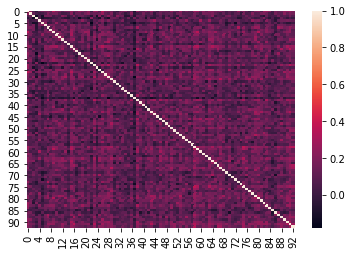

In [16]:
node = 10

sns.heatmap(ISC1[:,:,node])

#### Yep, looks good!

# Inter-subject RSA: Theory & simulations

- “Model-free” analyses that exploit the time-locked nature of a stimulus across subjects—e.g., inter-subject correlation (ISC) and related approaches—are a powerful way to analyze naturalistic neuroimaging data
- These approaches reveal spatiotemporal patterns of brain activity that are common across subjects
- However, brain activity during naturalistic stimuli also shows interesting individual differences

### Q: Can we develop & extend inter-subject approaches to study what is **different** across subjects, rather than what is common?

One problem is that ISC by definition operates at the level of subject pairs, while traits and behaviors operate at the level of single subjects. So, how can we relate ISC (one measure per subject pair) to behavior (one measure per subject)?

A. Representational similarity analysis!

If we take our subjects-by-subjects ISC matrix to be a "brain similarity" matrix, we can construct a "behavioral similarity" matrix and use RSA to find brain regions where subjects who are more similar in their behavior are also more similar in their neural response.

Sounds straightforward on its face, but when we talk about "similarity" between a given subject pair, not all similarity measures are created equal. Let's do some simuluations and visualizations to illustrate this.

In [17]:
# First, choose number of subjects and simulate behavior chosen from random distribution
n_subs = 30
behav = np.random.randn(n_subs)
behav_rank = sp.stats.rankdata(behav)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

In a typical RSA analysis, we would use something like Euclidean distance (or its inverse, so we can talk about similarity rather than distance). However, this makes a big assumption, namely that if two subjects score close to one another on the scale -- irrespective of whether they score high or low -- we expect them to look more similar to one another than two subjects whose scores are far apart. In other words, this would be a "nearest neighbor" scenario, where all that matters is your relative distance from your partner, and not where you score in an absolute sense.

If we visualize the sorted subjects x subjects ISC matrix, it would look like this (warmer colors indicate greater similarity):

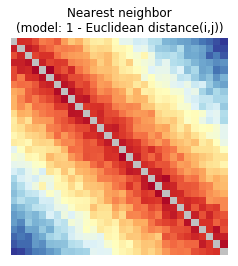

In [18]:
def sort_square_mtx(mtx, behav_vct):
    
    inds = behav_vct.argsort()
    mtx_sort = mtx
    mtx_sort = mtx_sort[inds, :]
    mtx_sort = mtx_sort[:, inds]
    
    return mtx_sort

isc_mtx = np.zeros((n_subs, n_subs))
noise_factor = 1

for i in range(n_subs):
    for j in range(n_subs):
        isc_mtx[i,j] = 1-abs(behav_rank[i]-behav_rank[j])+np.random.randn()*noise_factor
        
np.fill_diagonal(isc_mtx, np.nan)
  
fig, ax = plt.subplots()
ax = sns.heatmap(sort_square_mtx(isc_mtx, behav), cmap=cmap, square=True, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("Nearest neighbor\n(model: 1 - Euclidean distance(i,j))")
plt.show()

But what if that's not the case? What if the absolute position on the scale *does* matter, such that subjects that are high scoring look more similar to other high scorers, but less similar to low scorers? I call this the "Anna Karenina" scenario, since the most succinct way to describe is that "all high scorers are alike, all low scorers are low-scoring in their own way" (mirroring the famous opening quote from that novel, which reads "All happy families are alike; all unhappy families are unhappy in their own way"). 

Now if we visualize the matrix, it would look like this:

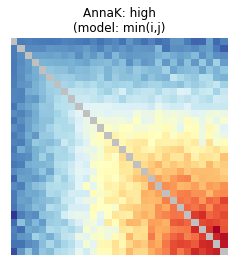

In [19]:
ak_high_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.05

for i in range(n_subs):
    for j in range(n_subs):
        ak_high_mtx[i,j] = min(behav_rank[i], behav_rank[j])+np.random.randn()*noise_factor*max(behav_rank[i], behav_rank[j])
        
np.fill_diagonal(ak_high_mtx, np.nan)
  
fig, ax = plt.subplots()
ax = sns.heatmap(sort_square_mtx(ak_high_mtx, behav), cmap=cmap, square=True, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("AnnaK: high\n(model: min(i,j)")
plt.show()

Of course, it would also be possible to have the reverse scenario, i.e., all *low* scorers are alike, whereas all *high* scorers are less similar to both one another and to low scorers. 

Or it could be a smoother-looking matrix, where high-low pairs show intermediate similarity to either low-low pairs or high-high pairs:

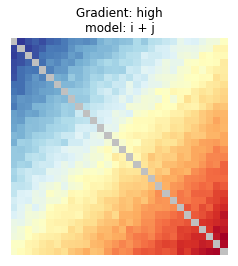

In [20]:
grad_high_mtx = np.zeros((n_subs, n_subs))
noise_factor = 1

for i in range(n_subs):
    for j in range(n_subs):
        grad_high_mtx[i,j] = (behav_rank[i] + behav_rank[j]) +np.random.randn()*noise_factor
        
np.fill_diagonal(grad_high_mtx, np.nan)
  
fig, ax = plt.subplots()
ax = sns.heatmap(sort_square_mtx(grad_high_mtx, behav), cmap=cmap, square=True, cbar=False, xticklabels=False, yticklabels=False)
ax.set_title("Gradient: high\nmodel: i + j")
plt.show()

# Inter-subject RSA: Application to real data

First, let's define some functions that will allow us to compute inter-subject behavioral similarity matrices using the various structures illustrated above.

In [21]:
def get_eucdist_pairwise_behav_vct(behav_vct):
    
    """
    Takes a vector of behavioral scores and returns the vectorized upper triangle 
    of a Euclidean distance matrix (i.e., "nearest neighors" similarity structure)
    """
    
    if len(behav_vct.shape)==1: # if it's 1d, reshape it to 2d
        behav_vct = behav_vct.reshape(-1,1)
    
    return np.divide(1,(1+sp.spatial.distance.pdist(behav_vct)))

In [22]:
def get_annak_pairwise_behav_vct(behav_vct, lower=False):
    
    """
    Takes a vector of behavioral scores (one per subject) and returns 
    the vectorized upper triangle of a similarity matrix constructed using the "Anna Karenina" principle
    (i.e., all high scorers are alike, all low scorers are low-scoring in their own way).
    
    If lower=True, the structure is reversed (i.e., all low scorers are alike, all high-scorers are different)
    """
    
    # Get dims
    n_subs = len(behav_vct)
    
    # Initialize output
    annak_mtx = np.zeros((n_subs,n_subs))

    # Fill in matrix
    for i in range(n_subs):
        for j in range(n_subs):
            if ~lower:
                annak_mtx[i,j] = min(behav_vct[i], behav_vct[j])
            if lower:
                # annak_mtx[i,j] = np.divide(1, (1+max(behav_vct[i], behav_vct[j])))
                # annak_mtx[i,j] = 1 / (1+max(behav_vct[i], behav_vct[j]))
                # annak_mtx[i,j] = 1 / max(behav_vct[i], behav_vct[j])
                annak_mtx[i,j] = 1 - max(behav_vct[i], behav_vct[j])
    
    # Return just the upper triangle
    annak_vct = annak_mtx[np.triu_indices(annak_mtx.shape[0], k=1)]
    return annak_vct

In [23]:
def get_gradient_pairwise_behav_vct(behav_vct):
    
    """
    Takes a vector of behavioral scores (one per subject) and returns 
    the vectorized upper triangle of a similarity matrix constructed using the "gradient" principle
    (i.e., high-high pairs are most alike, low-low pairs are most dissimilar, and high-low pairs show intermediate similarity).
    
    """
    
    # Get dims
    n_subs = len(behav_vct)
    
    # Initialize output
    gradient_mtx = np.zeros((n_subs,n_subs))

    # Fill in matrix
    for i in range(n_subs):
        for j in range(n_subs):
            gradient_mtx[i,j] = behav_vct[i] + behav_vct[j]
    
    # Return just the upper triangle
    gradient_vct = gradient_mtx[np.triu_indices(gradient_mtx.shape[0], k=1)]
    return gradient_vct

One final case we haven't touched on yet is when you have a vector of behavior for each individual subject (e.g., responses to individual items on a questionnaire) and you want to compute Euclidean distance between the itemwise answers, rather than the summary score (this is a variant on the nearest-neighbors model):

In [34]:
def get_behav_from_regex(behav_data, behav_regex, likert_map=None):
    
    """
    Gets selected items (via regex) from a behavioral dataframe. For doing Euclidean distance 
    in cases where you have a vector of responses for each subject (rather than a single scalar)
    
    If answers are non-numerical (e.g., Strongly Agree/Agree/etc from a likert scale), 
    you can optionally pass a likert_map to map these to numerical values
    
    Output can be fed directly into get_eucdist_pairwise_behav_vct
    """
    
    behav_vct = behav_data.filter(regex=behav_regex)
    
    if likert_map:
        behav_vct = behav_vct.replace(likert_map)
    
    return behav_vct

#### Next, let's define a function that actually does the inter-subject RSA:

In [35]:
def do_rsa(nodewise_isc_data, pairwise_behav_vct, n_perms=1000, method='spearman'):
    
    """
    This function computes RSA between brain similarity matrices (ISC) and a behavioral similarity matrix.
    
    Per the output of Mantel.test, the output is a N x 3, where N is the number of nodes, 
    and each row contains the RSA r-value, p-value (based on Mantel permutation test) and z-score, respectively
    """
    
    # Get dims
    n_nodes = nodewise_isc_data.shape[2]
    
    # Initialize output
    result = []

    # Enter node loop
    for nn in range(n_nodes):
        isc_vct = nodewise_isc_data[:,:,nn][np.triu_indices(nodewise_isc_data.shape[0], k=1)]
        tmp = Mantel.test(isc_vct, pairwise_behav_vct, perms=n_perms, method=method)
        result.append(tmp)
            
    return result

This is an exploratory analysis, and we expect that effects will subtle, so Bonferroni correction across 268 nodes is probably too strict. That said, we want to make every effort to ensure that we are visualizing and interpreting effects that are replicable.

Therefore, for every model we run, our pipeline will be as follows:
    - compute intersubject-RSA separately in each cohort
    - plot RSA values across the two cohorts to see how replicable effects are  
    - only visualize/interpret nodes that meet statistical significance in both cohorts
    
The following functions implement that workflow.

In [36]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

In [37]:
def plot_set1_vs_set2(result1, result2, tuple_index=0, ax=None, opacity=1, color="gray", p_alpha = 0.05, sig_color=None):
    
    # If no pre-existing axis was specified, make a new fig/ax
    ax = ax or plt.gca()
    
    # Set up axis with identity line
    line = mlines.Line2D([0, 1], [0, 1], color='gray', linestyle='--')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    # sns.set_style("white")
    
    if sig_color:
        colors = []
        sizes = []
        
        surv1 = np.array([x[1] for x in result1]) < p_alpha # does it survive in result 1?
        surv2 = np.array([x[1] for x in result2]) < p_alpha # does it survive in result 2?
        signs = [np.sign(result1[x][0])==np.sign(result2[x][0]) for x in range(len(result1))] # are the signs the same?
        surv_bool = np.logical_and.reduce((surv1, surv2, signs)) # combine all three above

        for node in range(len(result1)):
            if surv_bool[node]:
                colors.append(sig_color)
                sizes.append(40)
            else:
                colors.append(color)
                sizes.append(4)
    else:
        colors = color
        sizes = 4
    
    # Make scatter plot
    ax.scatter([x[tuple_index] for x in result1], [x[tuple_index] for x in result2], s=sizes, color=colors, alpha=opacity)
    ax.set_xlabel("subj_set1 RSA r-value")
    ax.set_ylabel("subj_set2 RSA r-value")
    # ax.set_title(title)
    ax.axhline(y=0, color="gray")
    ax.axvline(x=0, color="gray")

    # Make aspect ratio/scaling equal
    set_aspect_ratio(ax)
    
    # Make ticks the same
    ax.set_xticks(ax.get_yticks())
    ax.set_xticklabels(ax.get_yticklabels())

    # Annotate with r-value
    r = sp.stats.pearsonr([x[tuple_index] for x in result1], [x[tuple_index] for x in result2])[0]
    ax.annotate(f"r = {r:.2f}", xy=(0.1,0.9), xycoords="axes fraction", fontsize=14)
    
    return ax

In [38]:
def get_intersection(result1, result2, alpha=0.05):
    
    """
    This function assumes you are passing a "results" tuple with r-values in the first column 
    and p-values in the second column (e.g., output of do_rsa). It returns nodes that pass the statistical threshold in both cohorts.
    """
    
    surv1 = np.array([x[1] for x in result1]) < alpha # does it survive in result 1?
    surv2 = np.array([x[1] for x in result2]) < alpha # does it survive in result 2?
    signs = [np.sign(result1[x][0])==np.sign(result2[x][0]) for x in range(len(result1))] # are the signs the same?
    
    surv_bool = np.logical_and.reduce((surv1, surv2, signs))
    surv_nodes = np.where(surv_bool)[0]
    
    return surv_bool

In [39]:
def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    
    shen268 = nib.load(top_dir+"shen_2mm_268_parcellation.nii.gz")
    shen268_data = shen268.get_data()
    img = np.zeros(shen268_data.shape)

    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

#### Ok, let's put it all together:

In [40]:
def compare_models(behav_name, clip_name, models, GSR=0, n_perms=1000, alpha=0.05, color_names=None):
    
    """
    This function does it all! (kinda)
    """
    
    # Generate custom colormap
    legend_handles = models + ["Both {} and {}".format(models[0], models[1])]
    color_dict = {}
    
    if color_names is None:
        color_names = ["tab:blue", "tab:red", "tab:purple"]
    color_dict = dict(zip(legend_handles, color_names))

    # cmap = colors.ListedColormap(color_dict.values())
    cmap = mpl.colors.ListedColormap([color_dict.values()])
    bounds = [1,2,3,4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

    # Figure out which run this clip is in
    if "MOVIE" in clip_name: #...unless it's just MOVIE1, MOVIE2, MOVIE3 or MOVIE4, in which case use the whole run
        run_name = clip_name
        tr_range = None
    else:
        run_name = video_tr_lookup.query('clip_name==@clip_name')["run"].values[0]
        tr_range = get_clipwise_trs(clip_name)

    # Assemble full filename
    if GSR==0:
        f_suffix = "_shen268_roi_ts.txt"
    elif GSR==1:
        f_suffix = "_shen268_roi_ts_gsr.txt"
    f_name = "_" + run_name + f_suffix

    # Get final list of subjects (based on who has this run)
    good_subs1 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set1)
    good_subs2 = get_subjects(data_dir=data_dir, f_name=f_name, full_subj_list=subj_set2)

    # Read in timeseries data
    D1 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs1)
    D2 = make_3d_data_mtx(data_dir=data_dir, f_name=f_name, subj_list=good_subs2)

    # Make nodewise ISC matrices
    ISC1 = make_nodewise_isc_mtx(D1, tr_range)
    ISC2 = make_nodewise_isc_mtx(D2, tr_range)

    # Get vectors of behavior
    behav_vct1 = behav_data.loc[good_subs1, behav_name].values.reshape(-1,1)
    behav_vct2 = behav_data.loc[good_subs2, behav_name].values.reshape(-1,1)

    # Set up figure and subplots
    n_models = len(models)

    fig = plt.figure(figsize=(7,5))
    fig.suptitle(f"Behav: {behav_name} / Clip: {clip_name} / GSR: {GSR}")
    gs = mpl.gridspec.GridSpec(2, n_models, figure=fig)

    model_results = pd.DataFrame(columns=models)

    # Run RSA for desired models
    for m,model in enumerate(models):

        # Create an axis for the scatterplot for this model
        ax = fig.add_subplot(gs[0,m])

        # Run model
        if model=="NN":
            result1 = do_rsa(ISC1, get_eucdist_pairwise_behav_vct(behav_vct1), n_perms=n_perms)
            result2 = do_rsa(ISC2, get_eucdist_pairwise_behav_vct(behav_vct2), n_perms=n_perms)
        elif model=="AnnaK_high":
            result1 = do_rsa(ISC1, get_annak_pairwise_behav_vct(behav_vct1), n_perms=n_perms)
            result2 = do_rsa(ISC2, get_annak_pairwise_behav_vct(behav_vct2), n_perms=n_perms)
        elif model=="AnnaK_low":
            result1 = do_rsa(ISC1, get_annak_pairwise_behav_vct(behav_vct1, lower=True), n_perms=n_perms)
            result2 = do_rsa(ISC2, get_annak_pairwise_behav_vct(behav_vct2, lower=True), n_perms=n_perms)
        elif model=="gradient":   
            result1 = do_rsa(ISC1, get_gradient_pairwise_behav_vct(behav_vct1), n_perms=n_perms)
            result2 = do_rsa(ISC2, get_gradient_pairwise_behav_vct(behav_vct2), n_perms=n_perms)
        else:
            raise ValueError('unknown model')
        
        # Make scatterplot
        plot_set1_vs_set2(result1, result2, p_alpha = alpha, sig_color=color_dict[model], ax=ax)
        set_aspect_ratio(ax)
        ax.set_title(model)

        # Get intersection of subj_set1 and subj_set2
        surv_nodes = get_intersection(result1, result2, alpha=alpha)
        model_results[model] = surv_nodes
            
    # Make glass brain axis
    ax_glassbrain = fig.add_subplot(gs[1,:]) # for glass brain figure

    # Color ROIs that were significant in each model separately
    display_mode = 'lzr'
    bounds = [0.5,1.5]

    for model in models:
        cmap = mpl.colors.ListedColormap([color_dict[model]])
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        img = color_rois(model_results[model])
        plotting.plot_glass_brain(img, axes=ax_glassbrain, cmap=cmap, norm=norm, display_mode=display_mode)
        
    # Color ROIs that were significant in both models
    cmap = mpl.colors.ListedColormap([color_dict["Both {} and {}".format(models[0], models[1])]])
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img_overlap = color_rois(model_results[models[0]] & model_results[models[1]])
    plotting.plot_glass_brain(img_overlap, axes=ax_glassbrain, cmap=cmap, norm=norm, display_mode=display_mode)
    
    # Make legend
    patches = [ mpl.patches.Patch(color=color_names[i], label="{:s}".format(legend_handles[i]) ) for i in range(len(legend_handles)) ]
    ax_glassbrain.legend(handles=patches)
    
    return model_results

As a first pass, let's see how the NN and AnnaK models compare for looking at how ISC relates to fluid intelligence (PMAT) score. A priori we might expect that subjects who score higher on fluid intelligence look more similar to one another during movie watching, so the AnnaK model would capture this better.

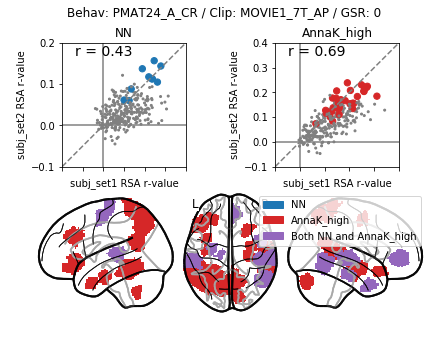

In [41]:
model_results = compare_models(behav_name = "PMAT24_A_CR", clip_name = "MOVIE1_7T_AP", models = ["NN", "AnnaK_high"])

** wish list for figure: **
    - equal xmin/xmax and ymin/ymax for the two scatterplots
    - xticklabels (wtf)
    - move legend off brain 

So we see that compared to the NN model, the "AnnaK" model yields larger effect sizes that are more consistent across the two cohorts, and that it is more sensitive in that it picks up more nodes (purple nodes are those that were picked up by both models, while red nodes were picked up only by the AnnaK model; no nodes were picked up by only the NN model).

How about for a behavior that's not necessarily about cognitive performance (where there is a clear "better" and "worse" end of the spectrum), but more value-agnostic (where the ends of the spectrum are simply different)? For example, Sadness_Unadj from the NIH Toolbox purports to measure "poor mood; negative perceptions of self, the world, and the future". Clearly it's better not to be sad, but as far as the brain is concerned we may not have a strong *a priori* hypothesis about whether this trait will follow more of a NN structure or an AnnaK structure -- since it's equally plausible that sad people will look similar to other sad people as happy people will look more similar to other happy people. When we run it, we see that far less of the brain is sensitive to this measure compared to fluid intelligence, but interestingly, one node in the left TPJ does seem to show a significant NN structure:

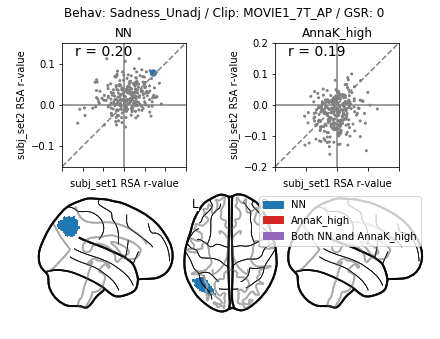

In [42]:
model_results = compare_models(behav_name = "Sadness_Unadj", clip_name = "MOVIE1_7T_AP", models = ["NN", "AnnaK_high"])

** side note: why the f is the left sagittal view flipped? **

What about for traits that are even more value-agnostic, like personality? Would we expect something like extraversion to be more of an NN-type or an AnnaK-type? Or maybe it could be either, depending on the brain region? Let's run our RSA models on the Big Five traits from the NEO Five-Factor Inventory: Agreeableness (A), Extraversion (E), Conscientiousness (C), Openness (O), and Neuroticism (N):

In [ ]:
NEOFAC_traits = ["NEOFAC_A", "NEOFAC_E", "NEOFAC_C", "NEOFAC_O", "NEOFAC_N"]

for trait in NEOFAC_traits:
    compare_models(behav_name = trait, clip_name = "MOVIE1_7T_AP", models = ["NN", "AnnaK_high"])

These results are largely underwhelming -- a few nodes show up here and there, but overall the results are weak and not very replicable across the two cohorts.

**BUT!** let's not forget that these 5 traits are just summary scores. Each subject filled out a 60-item questionnnaire. What if we formulated the NN model as Euclidean distance not between the summary scores, but between the entire vector of itemwise responses?

In [ ]:
behav_regex = "NEORAW_" # each individual item starts with this prefix
likert_map = {"SD": 1, "D": 2, "N": 3, "A": 4, "SA": 5}

behav_vct1 = get_behav_from_regex(behav_data=behav_data.loc[good_subs1, :], behav_regex=behav_regex, likert_map=likert_map)
behav_vct2 = get_behav_from_regex(behav_data=behav_data.loc[good_subs2, :], behav_regex=behav_regex, likert_map=likert_map)
result1_itemwise = do_rsa(ISC1, get_eucdist_pairwise_behav_vct(behav_vct1))
result2_itemwise = do_rsa(ISC2, get_eucdist_pairwise_behav_vct(behav_vct2))

# Set up plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 3]})

# Make scatterplot
plot_set1_vs_set2(result1_itemwise, result2_itemwise, sig_color="tab:green", ax=ax1)
set_aspect_ratio(ax1)
ax1.set_title('NN: Itemwise')

# Make glass brain plot
# make color map
bounds = [0.5,1.5]
cmap = mpl.colors.ListedColormap(["tab:green"])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
img = color_rois(get_intersection(result1_itemwise, result2_itemwise))
plotting.plot_glass_brain(img, cmap=cmap, norm=norm, axes=ax2)

plt.tight_layout()

Now we see that pairs of subjects that give similar item-level responses to the questionnaire look more similar during movie watching in several brain regions (especially in the cerebellum), regardless of their overall levels of each of the five summary dimensions. Interesting! 
